In [1]:
import gym
import matplotlib.pyplot as plt
import sys

sys.path.append('..')

# from rllr.gym_minigrid_navigation.utils import show_video

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
from torch import nn
import torch
import torch.nn.functional as F
import numpy as np

class StateSimilarityNetwork(nn.Module):
    
    def __init__(self, action_size, state_size):
        super(StateSimilarityNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(state_size[2], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(2*32, 128)
        self.fc3 = nn.Linear(128, 1)


    def forward(self, x, y):
        x = self.cnn(x.permute([0, 3, 1, 2]))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        
        y = self.cnn(y.permute([0, 3, 1, 2]))
        y = y.view(y.size()[0], -1)
        y = F.relu(self.fc1(y))
        
        
        z = torch.cat((x, y), 1)
        z = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(z))

In [86]:
from gym.wrappers import Monitor
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper


env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)

In [164]:
device = "cpu"

def rollout(env, max_steps=False):
    
    states, indices = [],  []
    done = False
    
    state = env.reset()
    i = 0
    
    while not done:
        action = env.action_space.sample()
        if i%2 ==0:
            action = 2
        next_state, _, done, _ = env.step(action)
        states.append(state['image'])
        state = next_state
        indices.append(i)
        if i > max_steps and max_steps:
            break
        i+=1
    
    
    return states, indices

In [192]:
def generate_batch(env, batch_size=128, radius=3):
    
    
    states1, states2, labels = [], [], []
    
    while len(labels) < batch_size:
        states, indices =  rollout(env)
        n = len(indices)
        
        for i in range(n):
            for j in range(n):
                if len(labels) >= batch_size:
                    break
                states1.append(states[i]/256.)
                states2.append(states[j]/256.)
                labels.append(int(abs(i-j)<radius))
            
    states1 = torch.from_numpy(np.array(states1)).to(device, dtype=torch.float32)
    states2 = torch.from_numpy(np.array(states2)).to(device, dtype=torch.float32)
    labels = torch.from_numpy(np.array(labels)).to(device, dtype=torch.float32)
    return states1, states2, labels

states1, states2, labels = generate_batch(env)
print(labels.size(), states1.size(), states2.size())

torch.Size([128]) torch.Size([128, 64, 64, 3]) torch.Size([128, 64, 64, 3])


In [193]:
labels

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1.])

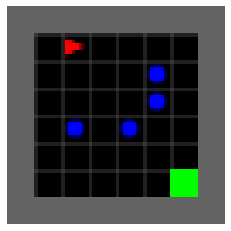

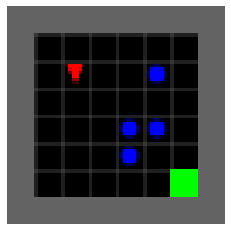

tensor(1.)

In [194]:
n = 14
plt.axis(False)
plt.imshow(states1[n].numpy())
plt.show()
plt.axis(False)
plt.imshow(states2[n].numpy())
plt.show()
labels[n]

In [195]:
from gym.wrappers import Monitor
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper


env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)

net = StateSimilarityNetwork(action_size = env.action_space.n, state_size = env.observation_space["image"].shape)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

verbose = 50
epochs = 1000
bce_loss  = nn.BCELoss()

l = 0

for epoch in range(epochs):
    
    
    states1, states2, labels = generate_batch(env, radius=3)
    
    for step in range(5):
        optimizer.zero_grad()
        predicted_labels = net.forward(states1, states2).squeeze()
        loss = bce_loss(predicted_labels, labels)
        loss.backward()
        optimizer.step()
    l+=loss.item()
        
    if (epoch+1)%verbose==0: 
        print("Epoch: {0}, loss: {1}".format(epoch+1, l/verbose))
        l = 0

Epoch: 50, loss: 0.6768992424011231
Epoch: 100, loss: 0.38147385984659193
Epoch: 150, loss: 0.30647447243332865
Epoch: 200, loss: 0.28793872371315954
Epoch: 250, loss: 0.226499480009079
Epoch: 300, loss: 0.19743834123015402
Epoch: 350, loss: 0.23275215052068232
Epoch: 400, loss: 0.18293082628399135
Epoch: 450, loss: 0.1595965550467372
Epoch: 500, loss: 0.2422980303876102
Epoch: 550, loss: 0.17007391460239887
Epoch: 600, loss: 0.1661630328372121
Epoch: 650, loss: 0.1672186231985688
Epoch: 700, loss: 0.14088176045566797
Epoch: 750, loss: 0.14302513174712658
Epoch: 800, loss: 0.1395667034201324
Epoch: 850, loss: 0.14170110251754522
Epoch: 900, loss: 0.1348903388902545
Epoch: 950, loss: 0.12805313352495432
Epoch: 1000, loss: 0.10685114722698927


In [ ]:
net = torch.load('../')

In [196]:
from gym.wrappers import Monitor
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper


env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)

In [306]:
states1, states2, labels = generate_batch(env, batch_size=1000)

In [307]:
def show_states(state1, state2):
    plt.axis(False)
    plt.imshow(state1)
    plt.show()
    plt.axis(False)
    plt.imshow(state2)
    plt.show()
    dist = net(state1.unsqueeze(0), state2.unsqueeze(0))
    print("Distance between states: ", dist.item())

In [308]:
neg = labels == 0
pos = labels == 1

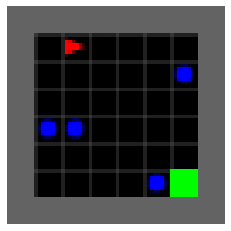

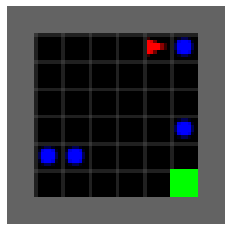

Distance between states:  0.000787039112765342


In [329]:
n = 4
show_states(states1[neg][n], states2[neg][n])

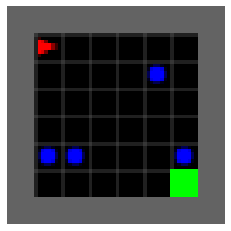

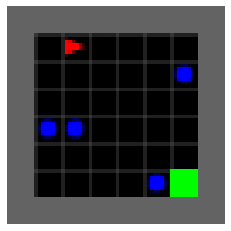

Distance between states:  0.9852877855300903


In [330]:
n = 1
show_states(states1[pos][n], states2[pos][n])

Average negative distance:  0.22021778
Average positive distance:  0.9114853


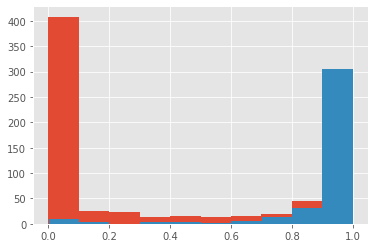

In [323]:
neg_dist = net(states1[neg], states2[neg]).detach().numpy()
pos_dist = net(states1[pos], states2[pos]).detach().numpy()

print("Average negative distance: ", np.mean(neg_dist))
print("Average positive distance: ", np.mean(pos_dist))

plt.hist(neg_dist)
plt.hist(pos_dist)
plt.show()

In [3]:
[1, 1, 1, 1, 0, 1, 1, 0].index(0)

4

# Train with rnd

In [27]:
import sys
sys.path.append('..')

In [28]:
from pyhocon.config_parser import ConfigFactory
from gym.wrappers import Monitor
from rllr.env.vec_wrappers import make_vec_envs
from rllr.utils.logger import init_logger
from rllr.utils import switch_reproducibility_on
from rllr.env.vec_wrappers import make_vec_envs
from experiments.train_ssim_with_rnd import train_ssim_with_rnd
from experiments.train_ssim_with_rnd import gen_env_with_seed
from experiments.train_ssim_with_rnd import get_agent, get_ssim


config = ConfigFactory.parse_file('../experiments/conf/minigrid_contrastive_ssim.hocon')
switch_reproducibility_on(config['seed'])


env = make_vec_envs(
        lambda env_id: lambda: gen_env_with_seed(config, env_id),
        config['training.n_processes'],
        config['agent.device']
    )

# env = Monitor(env, '../experiments/artifacts/video/', force=True)

agent = get_agent(env, config)
ssim = get_ssim(config)

print(f"Running agent training: { config['training.n_steps'] * config['training.n_processes']} steps")


train_ssim_with_rnd(
        env=env,
        agent=agent,
        ssim=ssim,
        conf=config
    )

Running agent training: 2048 steps


  0%|          | 0/976 [00:04<?, ?it/s]

Updates 0, num timesteps 2048, FPS 444 
Last 10 training episodes: mean/median reward -34.50/-18.50, min/max reward -81.00/-11.00
dist_entropy 1.38, value_loss 588.52, action_loss -0.00


FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/models/minigrid_ssim.p'

In [3]:
i = 29 
j = 20 
print(abs(i-j)==9)
print(abs(i-j)<3)

True
False


In [2]:
i = 29 
j = 19 
print(abs(i-j)==10)
print(abs(i-j)<3)



True
False


In [ ]:
ef rnd_obs(env, seed):
    env.seed(seed)
    while True:
        env.reset()
        goal_pos = np.random.randint(1, 6, 2)
        goal_dir = np.random.randint(0, 4)
        env.unwrapped.agent_pos = goal_pos
        env.unwrapped.agent_dir = goal_dir
        yield env.observation(env.unwrapped.gen_obs())

In [4]:
list(range(1, 6))

[1, 2, 3, 4, 5]